In [67]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import contextily as ctx
from matplotlib.patches import Patch
#change working directory
import os
from shapely import wkt
from sklearn.neighbors import NearestNeighbors

os.chdir(r'C:\Users\swl00\IFPRI Dropbox\Weilun Shi\monitoring-food-crises\New_WorkSpace\1.Source Data')
world = pd.read_csv('All_prediction.csv')


In [68]:

# convert area_id to integer, date to dtaetime
world['area_id'] = world['area_id'].astype(int)
world['date'] = pd.to_datetime(world['date'], format='%Y-%m-%d')
shape = pd.read_csv(r'C:\Users\swl00\IFPRI Dropbox\Weilun Shi\monitoring-food-crises\Weilun_workspace\(2) prepare for the new dataset\intermediate\geometry.csv')
# drop duplicates 
shape = shape.drop(columns=['year_month'])
shape = shape.drop_duplicates()
# convert shape to gpd
shape['geometry'] = shape['geometry'].apply(wkt.loads)
shape = gpd.GeoDataFrame(shape, geometry='geometry')
# genearate centroid for shape
shape['centroid'] = shape.geometry.centroid
shape['lat'] = shape.centroid.y
shape['lon'] = shape.centroid.x

shape = shape.drop(columns=['centroid'])
shape_coords_rad = np.radians(shape[['lat', 'lon']])
world_coords_rad = np.radians(world[['lat', 'lon']])

# 2. Initialize NearestNeighbors model
# We want to find 1 nearest neighbor ('n_neighbors=1')
# Use 'haversine' metric for geographic coordinates
nbrs = NearestNeighbors(n_neighbors=1, metric='haversine', algorithm='ball_tree')

# 3. Fit the model on the 'world' dataset coordinates
# We are looking for the closest point *in world_df* for each point in shape_df
nbrs.fit(world_coords_rad)

# 4. Find the nearest neighbor in 'world' for each point in 'shape'
# `kneighbors` returns two arrays:
# - distances: The distance to the nearest neighbor(s)
# - indices: The index (in `world_df`) of the nearest neighbor(s)
distances, indices = nbrs.kneighbors(shape_coords_rad)

# `indices` is a 2D array, flatten it to get the indices for the single nearest neighbor
nearest_world_indices = indices.flatten()

# 5. Add the matching index from 'world' to the 'shape' DataFrame
shape['matched_world_index'] = nearest_world_indices

# 6. (Optional) Add the actual matched lat/lon and ID from 'world' for verification
shape['matched_world_lat'] = world.loc[nearest_world_indices, 'lat'].values
shape['matched_world_lon'] = world.loc[nearest_world_indices, 'lon'].values
# Add the calculated distance (convert from radians back to a meaningful unit if needed, e.g., km)
# Haversine distance returned by sklearn is in radians (great-circle distance / Earth's radius)
# To get distance in kilometers, multiply by Earth's average radius (approx 6371 km)
earth_radius_km = 6371
shape['distance_km'] = distances.flatten() * earth_radius_km


# sort by distance_km
shape = shape.sort_values(by='distance_km')

# keep only first 1165 rows
shape = shape.head(1165)
# drop matched_world_index and distance_km
shape = shape.drop(columns=['matched_world_index', 'distance_km'])

# use shape to merge with world
world = world.merge(shape, left_on=['lat', 'lon'], right_on=['matched_world_lat', 'matched_world_lon'], how='left',indicator=True)
#drop lat_x, lon_x, lat_y, lon_y, lmatched_world_lat, matched_world_lon,_merge
world = world.drop(columns=['lat_x', 'lon_x', 'lat_y', 'lon_y', 'matched_world_lat', 'matched_world_lon', '_merge'])
# for each geometry, keep only first row
world = world.drop_duplicates(subset=['geometry'], keep='first')
gdf = gpd.GeoDataFrame(world, geometry='geometry')

# if overall_phase >= 3 , then set crisis actual to 1, else 0
gdf['crisis_actual'] = np.where(gdf['overall_phase'] >= 3, 1, 0)
gdf['crisis_pred'] = np.where(gdf['overall_phase_pred'] >= 3, 1, 0)
gdf['crisis_nowcast'] = np.where(gdf['nowcast_predict'] >= 3, 1, 0)


In [71]:
threshold = [0.2,0.4,0.6,0.67,0.8,0.91]
metric_frame = pd.DataFrame(columns=['threshold', 'recall_rate', 'precision_rate'])
for th in threshold:
    #sort gdf by phase3_pred, highest to lowest, then assign the top 67.24 percent of high phase3_pred obs crisis_pred = 1, rest crisis_pred = 0
    gdf = gdf.sort_values(by='overall_phase_pred', ascending=False)
    # reset index
    gdf = gdf.reset_index(drop=True)
    # calculate the number of rows to assign crisis_pred = 1
    num_rows = int(len(gdf) * th)
    # assign crisis_pred = 1 for the top num_rows rows
    gdf.loc[:num_rows - 1, 'crisis_pred'] = 1
    # assign crisis_pred = 0 for the rest
    gdf.loc[num_rows:, 'crisis_pred'] = 0

    #do rge same for crisis_nowcast
    gdf = gdf.sort_values(by='nowcast_predict', ascending=False)
    # reset index
    gdf = gdf.reset_index(drop=True)
    # calculate the number of rows to assign crisis_nowcast = 1
    num_rows_nowcast = int(len(gdf) * th)
    # assign crisis_nowcast = 1 for the top num_rows_nowcast rows
    gdf.loc[:num_rows_nowcast - 1, 'crisis_nowcast'] = 1
    # assign crisis_nowcast = 0 for the rest
    gdf.loc[num_rows_nowcast:, 'crisis_nowcast'] = 0
    
    # calculate recall rate 
    recall_rate = gdf[gdf['crisis_actual'] == 1]['crisis_pred'].sum() / gdf['crisis_actual'].sum()
    # calculate precision rate
    precision_rate = gdf[gdf['crisis_pred'] == 1]['crisis_actual'].sum() / gdf['crisis_pred'].sum()
    #concatenate the results
    metric_frame = pd.concat([metric_frame, pd.DataFrame({'threshold': [th], 'recall_rate': [recall_rate], 'precision_rate': [precision_rate]})], ignore_index=True)
    
# save the metric_frame to csv
metric_frame.to_csv('metric_frame.csv', index=False)


C:\Users\swl00\AppData\Local\Temp\ipykernel_8616\2734043324.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metric_frame = pd.concat([metric_frame, pd.DataFrame({'threshold': [th], 'recall_rate': [recall_rate], 'precision_rate': [precision_rate]})], ignore_index=True)


In [ ]:

gdf['fail_to_detect'] = np.where((gdf['crisis_actual'] == 1) & (gdf['crisis_pred'] == 0), 1, 0)
gdf['wrongly_detect']= np.where((gdf['crisis_actual'] == 0) & (gdf['crisis_pred'] == 1), 1, 0)

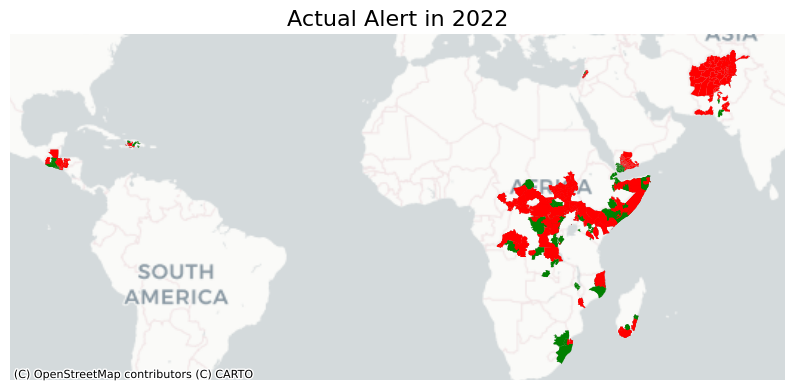

In [54]:

if gdf.crs is None:
     print("Warning: CRS not found in source file, assuming EPSG:4326")
     gdf.crs = "EPSG:4326"
elif gdf.crs.to_string() != "EPSG:4326":
     print(f"Warning: Original CRS is {gdf.crs}. Will reproject from this.")
     # If the CRS is already known but different, you might skip gdf.crs = ... above

# --- Reproject to Web Mercator (EPSG:3857) for contextily ---
# Now gdf is a GeoDataFrame object, so .to_crs() will work
gdf = gdf.to_crs(epsg=3857) # <--- This should work now

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# --- Plot the GeoDataFrame layers (using the reprojected data) ---
# Plot the base shapes
gdf.plot(ax=ax, color='white', alpha=0.5, edgecolor='k', linewidth=0.1)

# Plot conditional crisis phases
if 0 in gdf['crisis_actual'].unique():
    gdf[gdf['crisis_actual'] == 0].plot(ax=ax, color='green')
if 1 in gdf['crisis_actual'].unique():
    gdf[gdf['crisis_actual'] == 1].plot(ax=ax, color='red')

# --- Add the basemap using contextily ---
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# --- Turn off the axis display ---
ax.set_axis_off()

# --- Create and place the legend ---
colors_labels = {0: ('green', 'No Crisis'), 1: ('red', 'Crisis')}
legend_handles = [Patch(color=color, label=label)
                  for phase, (color, label) in colors_labels.items()
                  if phase in gdf['overall_phase'].unique()]
if legend_handles:
    ax.legend(handles=legend_handles, title="Has Alert (Overall Phase >=3)", loc='upper left')

# Add title using ax.set_title
ax.set_title('Actual Alert in 2022', fontsize=16)

# Show plot
plt.show()

#save plot
fig.savefig(r'2022_actual_alert.png', dpi=300, bbox_inches='tight')

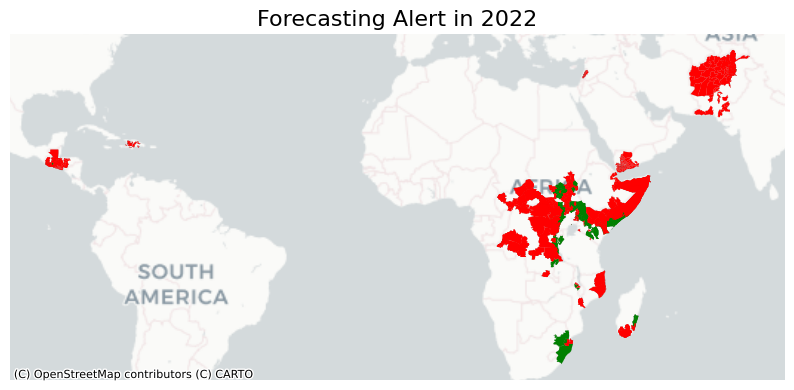

In [59]:
if gdf.crs is None:
     print("Warning: CRS not found in source file, assuming EPSG:4326")
     gdf.crs = "EPSG:4326"
elif gdf.crs.to_string() != "EPSG:4326":
     print(f"Warning: Original CRS is {gdf.crs}. Will reproject from this.")
     # If the CRS is already known but different, you might skip gdf.crs = ... above

# --- Reproject to Web Mercator (EPSG:3857) for contextily ---
# Now gdf is a GeoDataFrame object, so .to_crs() will work
gdf = gdf.to_crs(epsg=3857) # <--- This should work now

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# --- Plot the GeoDataFrame layers (using the reprojected data) ---
# Plot the base shapes
gdf.plot(ax=ax, color='white', alpha=0.5, edgecolor='k', linewidth=0.1)

# Plot conditional crisis phases
if 0 in gdf['crisis_pred'].unique():
    gdf[gdf['crisis_pred'] == 0].plot(ax=ax, color='green')
if 1 in gdf['crisis_pred'].unique():
    gdf[gdf['crisis_pred'] == 1].plot(ax=ax, color='red')

# --- Add the basemap using contextily ---
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# --- Turn off the axis display ---
ax.set_axis_off()

# --- Create and place the legend ---
colors_labels = {0: ('green', 'No Crisis'), 1: ('red', 'Crisis')}
legend_handles = [Patch(color=color, label=label)
                  for phase, (color, label) in colors_labels.items()
                  if phase in gdf['overall_phase_pred'].unique()]
if legend_handles:
    ax.legend(handles=legend_handles, title="Has Alert (Overall Phase >=3)", loc='upper left')

# Add title using ax.set_title
ax.set_title('Forecasting Alert in 2022', fontsize=16)

# Show plot
plt.show()
fig.savefig(r'2022_forecast_alert.png', dpi=300, bbox_inches='tight')

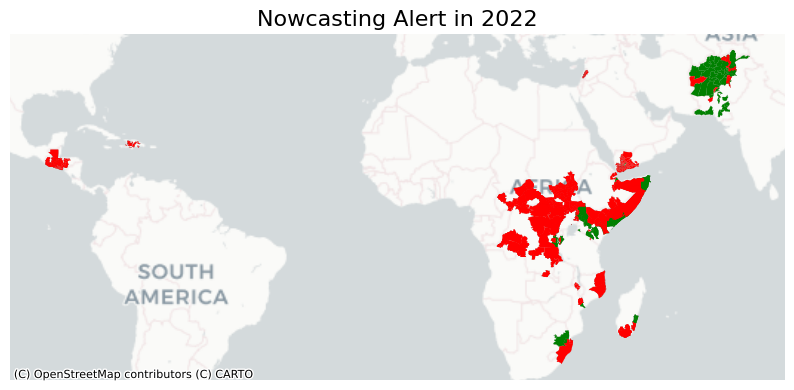

In [64]:
if gdf.crs is None:
     print("Warning: CRS not found in source file, assuming EPSG:4326")
     gdf.crs = "EPSG:4326"
elif gdf.crs.to_string() != "EPSG:4326":
     print(f"Warning: Original CRS is {gdf.crs}. Will reproject from this.")
     # If the CRS is already known but different, you might skip gdf.crs = ... above

# --- Reproject to Web Mercator (EPSG:3857) for contextily ---
# Now gdf is a GeoDataFrame object, so .to_crs() will work
gdf = gdf.to_crs(epsg=3857) # <--- This should work now

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# --- Plot the GeoDataFrame layers (using the reprojected data) ---
# Plot the base shapes
gdf.plot(ax=ax, color='white', alpha=0.5, edgecolor='k', linewidth=0.1)

# Plot conditional crisis phases
if 0 in gdf['crisis_nowcast'].unique():
    gdf[gdf['crisis_nowcast'] == 0].plot(ax=ax, color='green')
if 1 in gdf['crisis_nowcast'].unique():
    gdf[gdf['crisis_nowcast'] == 1].plot(ax=ax, color='red')

# --- Add the basemap using contextily ---
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# --- Turn off the axis display ---
ax.set_axis_off()

# --- Create and place the legend ---
colors_labels = {0: ('green', 'No Crisis'), 1: ('red', 'Crisis')}
legend_handles = [Patch(color=color, label=label)
                  for phase, (color, label) in colors_labels.items()
                  if phase in gdf['overall_phase_pred'].unique()]
if legend_handles:
    ax.legend(handles=legend_handles, title="Has Alert (Overall Phase >=3)", loc='upper left')

# Add title using ax.set_title
ax.set_title('Nowcasting Alert in 2022', fontsize=16)

# Show plot
plt.show()
fig.savefig(r'2022_nowcast_alert.png', dpi=300, bbox_inches='tight')

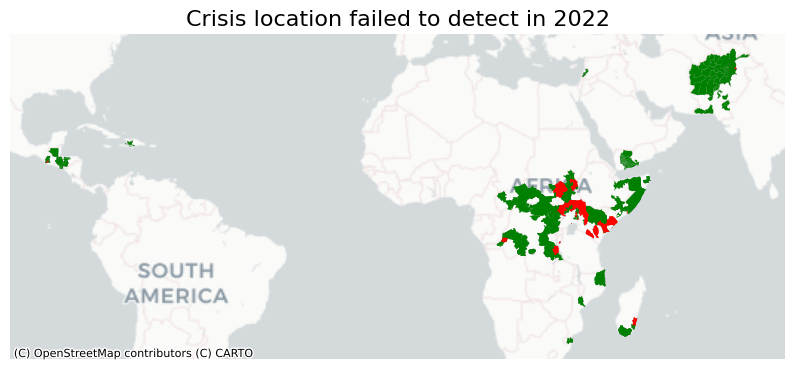

In [65]:
gdf_crisis = gdf[gdf['crisis_actual'] == 1] 
if gdf_crisis.crs is None:
     print("Warning: CRS not found in source file, assuming EPSG:4326")
     gdf_crisis.crs = "EPSG:4326"
elif gdf_crisis.crs.to_string() != "EPSG:4326":
     print(f"Warning: Original CRS is {gdf_crisis.crs}. Will reproject from this.")
     # If the CRS is already known but different, you might skip gdf.crs = ... above

# --- Reproject to Web Mercator (EPSG:3857) for contextily ---
# Now gdf is a GeoDataFrame object, so .to_crs() will work
gdf_crisis = gdf_crisis.to_crs(epsg=3857) # <--- This should work now

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# --- Plot the GeoDataFrame layers (using the reprojected data) ---
# Plot the base shapes
gdf_crisis.plot(ax=ax, color='white', alpha=0.5, edgecolor='k', linewidth=0.1)

# Plot conditional crisis phases
if 0 in gdf_crisis['fail_to_detect'].unique():
    gdf_crisis[gdf_crisis['fail_to_detect'] == 0].plot(ax=ax, color='green')
if 1 in gdf_crisis['fail_to_detect'].unique():
    gdf_crisis[gdf_crisis['fail_to_detect'] == 1].plot(ax=ax, color='red')

# --- Add the basemap using contextily ---
ctx.add_basemap(ax, crs=gdf_crisis.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# --- Turn off the axis display ---
ax.set_axis_off()

# --- Create and place the legend ---
colors_labels = {0: ('green', 'Detected'), 1: ('red', 'Not Detected')}
legend_handles = [Patch(color=color, label=label)
                  for phase, (color, label) in colors_labels.items()
                  if phase in gdf_crisis['overall_phase'].unique()]
if legend_handles:
    ax.legend(handles=legend_handles, title="Fail to detect", loc='upper left')

# Add title using ax.set_title
ax.set_title('Crisis location failed to detect in 2022', fontsize=16)

# Show plot
plt.show()

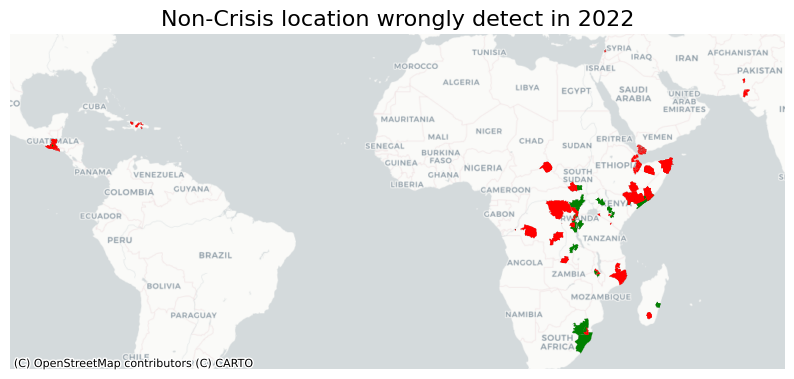

In [66]:
gdf_nocrisis = gdf[gdf['crisis_actual'] == 0] 
if gdf_nocrisis.crs is None:
     print("Warning: CRS not found in source file, assuming EPSG:4326")
     gdf_nocrisis.crs = "EPSG:4326"
elif gdf_nocrisis.crs.to_string() != "EPSG:4326":
     print(f"Warning: Original CRS is {gdf_nocrisis.crs}. Will reproject from this.")
     # If the CRS is already known but different, you might skip gdf.crs = ... above

# --- Reproject to Web Mercator (EPSG:3857) for contextily ---
# Now gdf is a GeoDataFrame object, so .to_crs() will work
gdf_nocrisis = gdf_nocrisis.to_crs(epsg=3857) # <--- This should work now

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# --- Plot the GeoDataFrame layers (using the reprojected data) ---
# Plot the base shapes
gdf_nocrisis.plot(ax=ax, color='white', alpha=0.5, edgecolor='k', linewidth=0.1)

# Plot conditional crisis phases
if 0 in gdf_nocrisis['wrongly_detect'].unique():
    gdf_nocrisis[gdf_nocrisis['wrongly_detect'] == 0].plot(ax=ax, color='green')
if 1 in gdf_nocrisis['wrongly_detect'].unique():
    gdf_nocrisis[gdf_nocrisis['wrongly_detect'] == 1].plot(ax=ax, color='red')

# --- Add the basemap using contextily ---
ctx.add_basemap(ax, crs=gdf_nocrisis.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# --- Turn off the axis display ---
ax.set_axis_off()

# --- Create and place the legend ---
colors_labels = {0: ('green', 'correctly detected'), 1: ('red', 'wrongly detected')}
legend_handles = [Patch(color=color, label=label)
                  for phase, (color, label) in colors_labels.items()
                  if phase in gdf_nocrisis['overall_phase'].unique()]
if legend_handles:
    ax.legend(handles=legend_handles, title="Wrongly Detected", loc='upper left')

# Add title using ax.set_title
ax.set_title('Non-Crisis location wrongly detect in 2022', fontsize=16)

# Show plot
plt.show()